##  Workflow

* Select a timeframe. (this month)
* Search for "woolworths australia"/"woolies" and retrieve tweets
* Get word frequencies
* See tweets with top words and get sentiments
* Pick out impactful tweets to read. (function of normalised quantities)
* Sentiment bar chart for the time frame


In [54]:
# import required libraries

import pandas as pd
import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import nltk
from transformers import pipeline
import snscrape.modules.twitter as sntwitter
from tqdm import tqdm
from datetime import datetime
from wordcloud import WordCloud

In [39]:
# function to get historical tweets with a search term

def retrieve_tweets(search_term, start, end):
    # Creating list to append tweet data to
    tweets_list2 = []

    # Gather data and append tweets to list
    ##yyyy-mm-dd
    for i,tweet in tqdm(enumerate(sntwitter.TwitterSearchScraper(search_term + ' since:'+start+' until:'+end).get_items())):
        if i>50000:
            break
        tweets_list2.append([tweet.date, tweet.id, tweet.content, tweet.user.username, tweet.user.followersCount, tweet.user.favouritesCount, tweet.user.location, tweet.user.friendsCount, tweet.retweetCount, tweet.likeCount, tweet.replyCount])

    # Creating a dataframe from the tweets list above
    df2 = pd.DataFrame(tweets_list2, columns=['Datetime', 'Tweet Id', 'Text', 'Username', 'Followers', 'Favourites', 'Location','Friends','Retweets', 'Tweet Likes', 'Tweet Replies'])
#     df['date'] = pd.to_datetime(df['Datetime'], format='%Y-%m-%d %X%z')
#     df['week'] = df.apply(lambda row: int(datetime.date(row.date).strftime("%V")) + int(row.Datetime[3])*52, axis=1)
    return df2

In [40]:
#get historical tweets and add some useful derivative columns

# df = retrieve_tweets('woolies','2021-01-01','2021-06-05')
df = pd.read_csv('data/woolies.csv')

try:
    df['date'] = df.apply(lambda row: row['Datetime'].to_pydatetime(), axis=1)
except:
    pass

try:
    df['week'] = df.apply(lambda row: int(datetime.date(row.Datetime.to_pydatetime()).strftime("%V"))%52, axis=1)
except:
    pass
df = df.drop(df[df['Text'].str.contains('WOOLWORTHS_SA')].index).reset_index(drop=True)
df = df.drop(df[df['Username'].str.contains('WOOLWORTHS_SA')].index).reset_index(drop=True)

df.head()

,Tweet Id,Text,Username,sentiment_prediction,Followers,User Favourites,Location,Friends,date,week,Retweets,Tweet Likes,Tweet Replies
0,1408192134365151232,Remember when VicGov got blasted for listing t...,toiletpaperaus1,negative,311.0,203.0,NaN,20.0,2021-06-24 22:35:42+00:00,77,2.0,21.0,1.0
1,1408162433252794373,A US tourist has rated Australia’s leading sup...,7NewsSydney,negative,345387.0,8715.0,Sydney,176.0,2021-06-24 20:37:41+00:00,77,0.0,3.0,2.0
2,1408162407923425284,A US tourist has rated Australia’s leading sup...,7NewsAustralia,negative,198672.0,627.0,Australia,187.0,2021-06-24 20:37:35+00:00,77,0.0,3.0,13.0
3,1408053912708390913,Public #Health alert - more venues of concern ...,MirageNewsCom,neutral,338.0,0.0,Australia,16.0,2021-06-24 13:26:27+00:00,77,0.0,0.0,0.0
4,1408025127791386626,Woolworths shares drop as Endeavour pubs busin...,Zicutake,negative,2010.0,21435.0,NaN,0.0,2021-06-24 11:32:04+00:00,77,0.0,0.0,0.0


In [41]:
# Define helper functions

numeric_cols = ['Followers','Retweets','Tweet Likes','Tweet Replies', 'User Favourites']

def get_tweets_with_word(df,word):
    return df[df['Text'].str.contains(word)].reset_index(drop=True)

def get_tweets_in_date(df, start, end): # dates as strings yyyy-mm-dd
    mask = (df['date'] > start) & (df['date'] <= end)
    return df.loc[mask].reset_index(drop=True)

def get_most_common_words(df, ignore_top=0):
    tweets = re.sub('\n', '', re.sub(r'[^a-zA-Z0-9\s\n]', '', ' '.join(list(df['Text']))))

    data = tweets.split(' ')

    stop_words = stopwords.words('english')

    filtered_data = [w for w in data if not w.lower() in stop_words]
    filtered_data = [word.lower() for word in filtered_data if word.isalpha()]

    fdist = nltk.FreqDist(filtered_data)

    words, freqs = map(list, zip(*fdist.most_common(50)))

    return fdist.most_common(1000)[ignore_top:]

def plot_most_common_words(df, ignore_top=0):
    tweets = re.sub('\n', '', re.sub(r'[^a-zA-Z0-9\s\n]', '', ' '.join(list(df['Text']))))

    plt.figure(figsize=(18, 6), dpi=80)

    data = tweets.split(' ')

    stop_words = stopwords.words('english')

    filtered_data = [w for w in data if not w.lower() in stop_words]
    filtered_data = [word.lower() for word in filtered_data if word.isalpha()]

    fdist = nltk.FreqDist(filtered_data)

    words, freqs = map(list, zip(*fdist.most_common(50)))

    plt.bar(words[ignore_top:], freqs[ignore_top:], width=0.5)
    plt.title('Word Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.show()
    
def just_words(wordfreq_tuplelist):
    return [i[0] for i in wordfreq_tuplelist]

# BE CAREFUL - USE FOR SMALL DATAFRAMES
def predict_sentiments(df2):
    df = df2
    classifier = pipeline('sentiment-analysis', model='cardiffnlp/twitter-roberta-base-sentiment')
    
    sent = {'LABEL_0': 'negative', 'LABEL_1': 'neutral', 'LABEL_2': 'positive'}

    res = classifier(list(df['Text']))
    df['sentiment_prediction'] = [sent[i['label']] for i in res]
    df['confidence'] = [i['score'] for i in res]
    return df

def normalise_columns(df2, cols):
    df = df2
    for col in cols:
        col_zscore = col + '_zscore'
        df[col_zscore] = (df[col] - df[col].mean())/df[col].std(ddof=0)
    return df

def get_most_impactful_tweets(df):
    n_df = normalise_columns(df, numeric_cols)
    n_df['score'] = 4*n_df['Followers_zscore']+4*n_df['Retweets_zscore']+n_df['Tweet Likes_zscore']+n_df['Tweet Replies_zscore']
    return n_df.sort_values(by=['score'],ascending=False).reset_index(drop=True)

In [42]:
# bot detection algorithm

import botometer

rapidapi_key = " "
twitter_app_auth = {
    'consumer_key': '',
    'consumer_secret': '',
    'access_token': '',
    'access_token_secret': '',
  }

bom = botometer.Botometer(wait_on_ratelimit=True,
                          rapidapi_key=rapidapi_key,
                          **twitter_app_auth)

# given a list of account names
# returns a list of tuples: (name, score out of 5)
def check_accounts(accounts):
    result = []
    for account in accounts:
        score = bom.check_account(account)
        result.append(tuple([account,score['display_scores']['english']['overall']]))
    return result
  
# given a list of list of tuples: (name, score out of 5)
# returns a list of account names which are unlikely to be a bot (score < 3.5)
def get_humans(accountScores):
    result = []
    threshold = 4
    for i_tuple in accountScores:
        account = i_tuple[0]
        score = i_tuple[1]
        if score < threshold:
            result.append(account)
    return result

#print(get_humans(check_accounts(["Sabrina46554824","tinycarebot"])))

In [43]:
# String distance measures

from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

def drop_sim(df2):
    df = df2
    inc_tweets=[]
    for i,row in df.iterrows():
        allow=True
        for t in inc_tweets:
            if (similar(row['Text'],t) > 0.9 and row['Text'] != t):
                allow = False
        if allow:
            inc_tweets += [row['Text']]
        else:
            df = df.drop([i])
    return df.reset_index(drop=True)

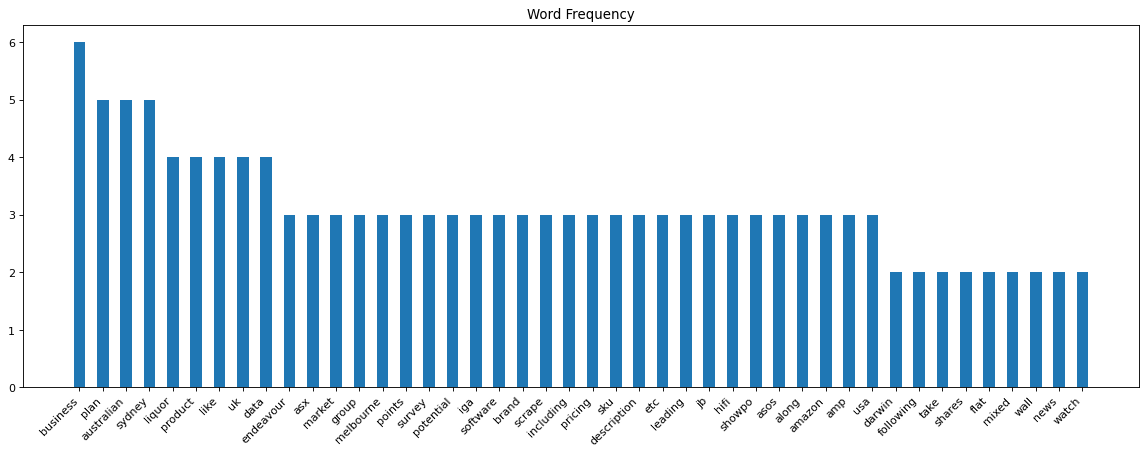

In [44]:
# get most impactful tweets and find the most common words in unique tweets

imp = get_most_impactful_tweets(get_tweets_with_word(get_tweets_in_date(df, '2021-04-25', '2021-06-25'), 'australia'))
f=drop_sim(imp)
plot_most_common_words(f,6)

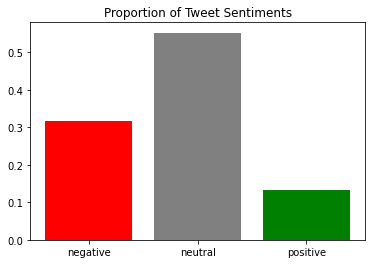

In [45]:
# plot the sentiment balance of this set of tweets

plt.bar(['negative', 'neutral', 'positive'], [sum(sum([f['sentiment_prediction'] == 'negative']))/len(f), sum(sum([f['sentiment_prediction'] == 'neutral']))/len(f),sum(sum([f['sentiment_prediction'] == 'positive']))/len(f)],color=['red','grey','green'])
plt.title('Proportion of Tweet Sentiments')
plt.show()

In [46]:
# NLP-esque functionalities

def extract_text(s):
    return re.sub('\n', '', re.sub(r'[^a-zA-Z0-9\s\n]', '', s))

def remove_stopwords(s):
    data = s.split(' ')
    stop_words = stopwords.words('english')
    filtered_data = [w for w in data if not w.lower() in stop_words]
    filtered_data = [word.lower() for word in filtered_data if word.isalpha()]
    return filtered_data

In [47]:
# top bigrams

from sklearn.feature_extraction.text import CountVectorizer
c_vec = CountVectorizer(stop_words=stopwords.words('english')+['woolies'], ngram_range=(2,3))
# matrix of ngrams
ngrams = c_vec.fit_transform(get_tweets_in_date(df,'2021-05-01','2021-06-01')['Text'])
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})

df_ngram.head(10)

,frequency,bigram/trigram
0,264,https co
1,41,woolworths australia
2,38,australia https co
3,38,australia https
4,27,coles woolworths
5,22,victoria australia
6,22,correct woolworths
7,21,name correct woolworths
8,21,name correct
9,19,guestposting australia


In [64]:
# usernames in most impactful tweets

for row in get_most_impactful_tweets(get_tweets_in_date(df,'2021-06-01','2021-06-25')).sample(20).iloc():
    print(f"Username: {row.Username}, Link: https://twitter.com/{row.Username}/status/{row['Tweet Id']}")

Username: _oftoday_, Link: https://twitter.com/_oftoday_/status/1405427027264651272
Username: CyberSecRicki, Link: https://twitter.com/CyberSecRicki/status/1407291877267632131
Username: marc_landy, Link: https://twitter.com/marc_landy/status/1406873517145006080
Username: VPickr, Link: https://twitter.com/VPickr/status/1407976948660269058
Username: MonexAustralia, Link: https://twitter.com/MonexAustralia/status/1407901870807453697
Username: Rob_Kimbell, Link: https://twitter.com/Rob_Kimbell/status/1404817621191696385
Username: UnoZwigs, Link: https://twitter.com/UnoZwigs/status/1401276065318899715
Username: woolworths, Link: https://twitter.com/woolworths/status/1400217463414050820
Username: AMSANTaus, Link: https://twitter.com/AMSANTaus/status/1402510612538662914
Username: hbowly, Link: https://twitter.com/hbowly/status/1405144483197378563
Username: globalfirstnews, Link: https://twitter.com/globalfirstnews/status/1402812693262737408
Username: SIADailyNews, Link: https://twitter.com/SI

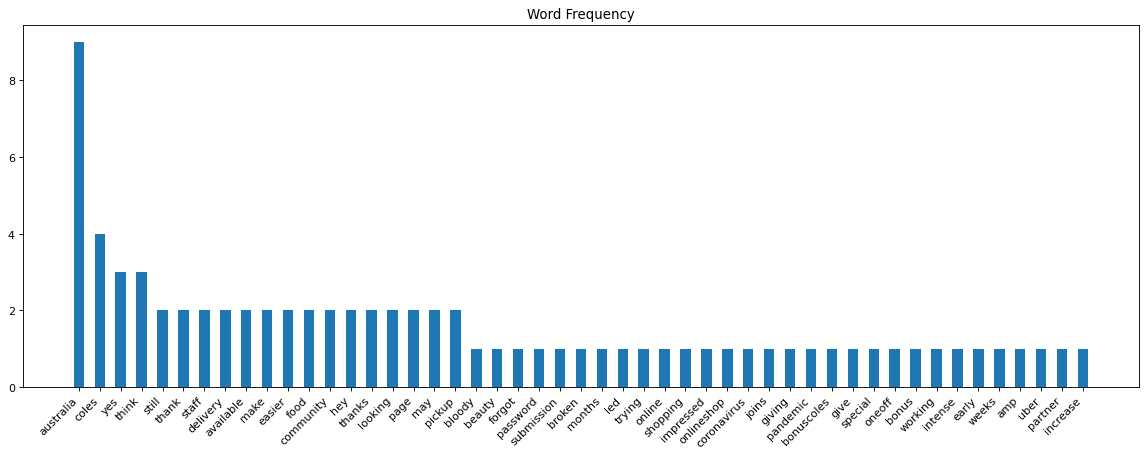

In [49]:
# predict sentiments, here it's precalculated and histogram

#f_w20 = predict_sentiments(df[df['week']==20])

plot_most_common_words(df_w20[df_w20['sentiment_prediction']=='positive'],1)

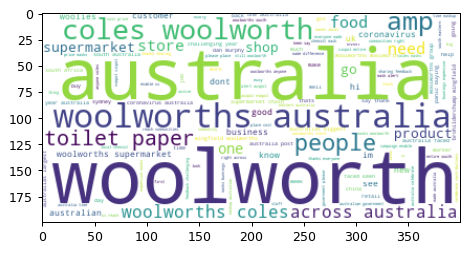

In [50]:
# top words in processed tweets

tweets = re.sub('\n', '', re.sub(r'[^a-zA-Z0-9\s\n]', '', ' '.join(list(df['Text']))))

plt.figure(figsize=(6, 6), dpi=90)

data = tweets.split(' ')

stop_words = stopwords.words('english')

filtered_data = [w for w in data if not w.lower() in stop_words]
filtered_data = [word.lower() for word in filtered_data if word.isalpha()]

wordcloud = WordCloud(background_color='white').generate(' '.join(filtered_data))

plt.imshow(wordcloud, interpolation='bilinear')

In [51]:
# food trends!

from nltk.corpus import wordnet as wn
food = wn.synset('food.n.02')
food_list = list(set([w.replace('_',' ') for s in food.closure(lambda s:s.hyponyms()) for w in s.lemma_names()]))

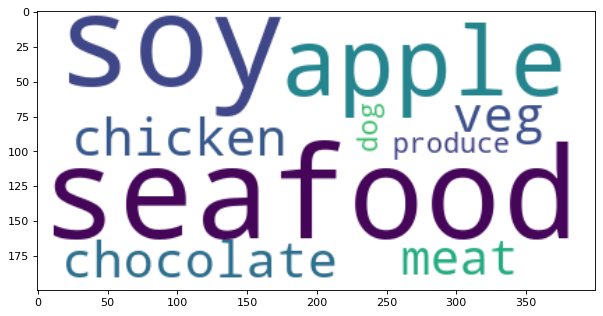

In [52]:
trending_food = []
for w in remove_stopwords(extract_text(' '.join(df[df['week']==19]['Text']))):
    if w in food_list:
        trending_food += [w]
#         print(w)


plt.figure(figsize=(9, 6), dpi=80)
wordcloud = WordCloud(background_color='white').generate(' '.join(trending_food))

plt.imshow(wordcloud, interpolation='bilinear')

In [56]:
top1000 = just_words(get_most_common_words(df,1))
top1000[0:10]

['australia',
 'coles',
 'supermarket',
 'australias',
 'amp',
 'coronavirus',
 'australian',
 'one',
 'people',
 'stores']

In [37]:
for tweet in [i for i in get_tweets_with_word(df,'tiktok')['Text']]:
    print(tweet, '\n')

Woolworths employee's TikTok reveals frustrating customer habit - Yahoo News Australia: Woolworths employee's TikTok reveals frustrating customer habit  Yahoo News Australia https://t.co/IR85YBTx5M #tiktok #tiktokindia #instagram https://t.co/S8OWrY0Q2L 

@newscomauHQ They’re a #tiktok user,
So automatically you know they’re a fool. #woolworths #australia 

AUSTRALIA IS SUFFERING #Coronavirus #toiletpaper #panicbuying #woolworths #coles #groceries #tiktok #FYP  https://t.co/ZTK3LJQzfI 



## end of demo

## We want to get text from the tweets that were posted each week aggregated

In [20]:
tweet_weeks = []
stop_words = stopwords.words('english')
for i in range(1,max(df['week'])):
    tweets = re.sub('\n', '', re.sub(r'[^a-zA-Z0-9\s\n]', '', ' '.join(list((df[df['week']==i]['Text'])))))

    data = tweets.split(' ')

    filtered_data = [w for w in data if not w.lower() in stop_words]
    filtered_data = [word.lower() for word in filtered_data if word.isalpha()]

    tweet_weeks += [filtered_data]

In [21]:
top1000 = just_words(get_most_common_words(df,1))

In [319]:
df = df.drop(df[df['Text'].str.contains('WOOLWORTHS_SA')].index).reset_index(drop=True)

In [239]:
# for i in df.sample(10)['Text']:
#     print(i)

In [244]:
from nltk.corpus import wordnet as wn
food = wn.synset('food.n.02')
food_list = list(set([w.replace('_',' ') for s in food.closure(lambda s:s.hyponyms()) for w in s.lemma_names()]))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [251]:
for w in top1000:
    if w in food_list:
        print(w)

meat
produce
roll
chocolate
fries
cut
pasta
beef
green
seafood


In [257]:
april = get_tweets_in_date(df, '2021-04-01', '2021-04-30')

In [277]:
for w in just_words(get_most_common_words(may)):
    if w in food_list:
        print(w)

beef
chocolate
steak
rump
lamb
jack
lemon
lime
shoulder
potato
game
pineapple
chilli
produce
cut
cookie


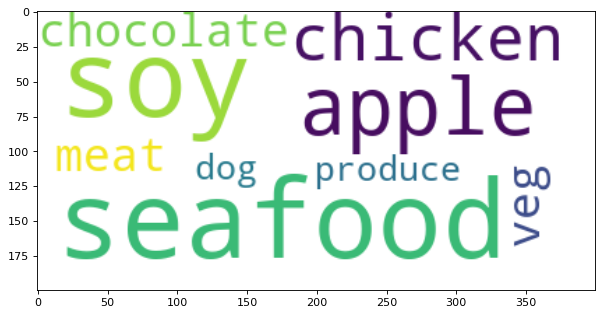

In [22]:
trending_food = []
for w in tweet_weeks[18]:
    if w in food_list:
        trending_food += [w]
#         print(w)


plt.figure(figsize=(9, 6), dpi=80)
wordcloud = WordCloud(background_color='white').generate(' '.join(trending_food))

plt.imshow(wordcloud, interpolation='bilinear')

In [420]:
for i in range(0,10):
    print(get_most_impactful_tweets(get_tweets_with_word(get_tweets_in_date(df, '2021-05-01', '2021-05-08'),'chocolate')).iloc()[i]['Text'])
    print('\n\n')

@ChristoThurston Mina nina ti recipe tinharhu. Vanilla cake, chocolate cake and banana loaf. To be honest I am proud about them and I prefer them to woolies cakes. https://t.co/s0frrRtLjy



Me too. A huge slice of cake or those chocolate cupcakes from woolies😭🥺 https://t.co/FkGIm1LEgY



I need that Woolies chocolate mousse 😭😭😭



My mum got an early mother's day gift from our neighbour. It's that Woolies Lemon cheesecake and chocolate. My mum is a diabetic. I'll be eating most of her gift 🥺❤

Thank you Sesi Mabore😂



@DERBS_P She buys carrot cake ko Woolies then turns to my friend ko spaza for chocolate cake, no wonder. @Tia_Mokoka Rrakgadi delete button ke mahala-hala 🤣🙏



@UmntwanakaLinda I have the chocolate cake from Woolies still. I have Lumis birthday cake also 😭😭 I realised uba in fact I need to cut down



I wanna eat a cake, and like specifically a woolies (or coles) mudcake. Idm the flavour like just gimme that sweetness, be it chocolate, white chocolate or caramel, I'm h

In [336]:
len(df)

37225

In [371]:
df['date'] = df.apply(lambda row: row['Datetime'].to_pydatetime(), axis=1)
df['week'] = df.apply(lambda row: int(datetime.date(row.Datetime.to_pydatetime()).strftime("%V"))%52, axis=1)

In [401]:
for i in range(0,12):
    print(get_tweets_with_word(df,'tiktok').iloc()[i]['Text'])

@soult Ah I was literally there yesterday filming woolies for a tiktok haha. So close yet so far!
Decided to duck down to woolies for some milk and encountered a fight at the station ... came back from woolies and there were some eshays being arrested ? And making a tiktok about being arrested ?
I saw this woolies eyeliner on tiktok and now I feel like I gotta get it,,, is this how capitalism works? https://t.co/59rHuvHtnX
yalls i was leaving my local woolies and one of the workers recognised me from tiktok 😂😭 @charlidamelio watch out
also I've never been more starstruck y'all the guy on tiktok that does all the Woolies shit and he works there goes to Macquarie. hopefully I run into him at Woolies sometime
@jalebi_bebe If people don't pick it up then ba slow... That caramel cake has a very distinct flavor infact all woolies cakes nje. I do not think people who sell cakes do this. It's just tiktok
Living in Cape Town is seeing that guy from die antwoord and the girl from tiktok who said

In [446]:
df = df.drop(df[df['Text'].str.contains('WOOLWORTHS_SA')].index).reset_index(drop=True)
df = df.drop(df[df['Username'].str.contains('WOOLWORTHS_SA')].index).reset_index(drop=True)

In [427]:
def extract_text(s):
    return re.sub('\n', '', re.sub(r'[^a-zA-Z0-9\s\n]', '', s))

def remove_stopwords(s):
    data = s.split(' ')
    stop_words = stopwords.words('english')
    filtered_data = [w for w in data if not w.lower() in stop_words]
    filtered_data = [word.lower() for word in filtered_data if word.isalpha()]
    return filtered_data

In [428]:
extract_text(' '.join(df[df['week']==20]['Text']))

'ComradeSkhokho I like Woolies Chris but am getting a little concerned about the valuation amp the possibility of a strongish pullback in the shorter term But next target is R60Anecdotally am hearing amp seeing on their online site more evidence of some return to basics Stuff is flying ZENTISKY Whoever decided to put these on the shelves at woolies is an Aussie icon fr motsolet tseepati Youre smoking woolies gwaais F1shyBob Deal I was holding out for Woolies mihle woolies mntase 021Bigbear HassanF And I saw a Muslim filling his boot from Woolies they liars Delux I know its only a small Metro Woolies but not a single lactose or dairy free milk or yogurt option  Girlll those canned soups from Woolies  damn Im making my mum post them to me chilee because I on my last one  httpstcoMcYlYHmYbD SottoDimitrios Its currently on special at uncle Wongs woolies httpstcoGVjJqAMSN8 mightystickbug We do most of our sharp at Aldi then pick up few items at coleswoolies so our frozen stuff from Aldi wil

In [437]:
from sklearn.feature_extraction.text import CountVectorizer
c_vec = CountVectorizer(stop_words=stopwords.words('english')+['woolies'], ngram_range=(2,3))
# matrix of ngrams
ngrams = c_vec.fit_transform(get_tweets_in_date(df,'2021-05-01','2021-06-01')['Text'])
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})

In [438]:
df_ngram.head(50)

,frequency,bigram/trigram
0,1654,https co
1,112,pick mix
2,64,ice cream
3,53,contact tracers
4,51,gt gt
5,46,epping north
6,43,toilet paper
7,40,pick pay
8,34,contact tracing
9,33,years ago


In [447]:
for row in get_most_impactful_tweets(get_tweets_in_date(df,'2021-06-01','2021-06-25')).iloc():
    print(f"Username: {row.Username}, Link: https://twitter.com/{row.Username}/status/{row['Tweet Id']}")

Username: Karabo_Mokgoko, Link: https://twitter.com/Karabo_Mokgoko/status/1400447464679690240
Username: HaydenJOConnor, Link: https://twitter.com/HaydenJOConnor/status/1399919203054804992
Username: btckr, Link: https://twitter.com/btckr/status/1399559868067901442
Username: MatthewGuyMP, Link: https://twitter.com/MatthewGuyMP/status/1399566628698787848
Username: Lennethxvii, Link: https://twitter.com/Lennethxvii/status/1399932159729618944
Username: sandy_zwane, Link: https://twitter.com/sandy_zwane/status/1400081020699955200
Username: oldshopsoz, Link: https://twitter.com/oldshopsoz/status/1399687491431538688
Username: chardycatt, Link: https://twitter.com/chardycatt/status/1399829779780497411
Username: MandisaShuku, Link: https://twitter.com/MandisaShuku/status/1400806344291143682
Username: aus_spirit, Link: https://twitter.com/aus_spirit/status/1399879593880784898
Username: AshleyLeahy, Link: https://twitter.com/AshleyLeahy/status/1400074855517589507
Username: Lennethxvii, Link: https

Username: loisnomad, Link: https://twitter.com/loisnomad/status/1400129426910810119
Username: ezdlc, Link: https://twitter.com/ezdlc/status/1399788848369000448
Username: iamdaniela, Link: https://twitter.com/iamdaniela/status/1400309698637615107
Username: auskp69, Link: https://twitter.com/auskp69/status/1399987925421465604
Username: adoreluce, Link: https://twitter.com/adoreluce/status/1400669226055049217
Username: selaone, Link: https://twitter.com/selaone/status/1400000877763731457
Username: mothermajito, Link: https://twitter.com/mothermajito/status/1399739866737524740
Username: JaneTaylore, Link: https://twitter.com/JaneTaylore/status/1399664779740938241
Username: Tryphin78127919, Link: https://twitter.com/Tryphin78127919/status/1400839758918701058
Username: Lesego_P, Link: https://twitter.com/Lesego_P/status/1400142845462433802
Username: MmachueneMich, Link: https://twitter.com/MmachueneMich/status/1399659266257084417
Username: Faster_Martyr, Link: https://twitter.com/Faster_Mart

In [448]:
#looking for #fetapasta #bakedfetapasta

alltext = ' '.join(df['Text'])

In [460]:
alltext.lower().count('#fetapasta')

0

In [463]:
alltext.count('#')

5818

In [464]:
df

,Datetime,Tweet Id,Text,Username,Followers,Favourites,Location,Friends,Retweets,Tweet Likes,Tweet Replies,date,week
0,2021-06-04 23:54:45+00:00,1400964268892295169,Tiramisu cake from Woolies would definitely sl...,_mgrey,3651,117989,South Africa,2409,0,2,0,2021-06-04 23:54:45+00:00,22
1,2021-06-04 23:53:34+00:00,1400963971604045828,Are these community acquired Covid cases all f...,2Detracter,203,273,Blue Mountains,596,0,2,0,2021-06-04 23:53:34+00:00,22
2,2021-06-04 23:41:35+00:00,1400960956214124544,@crackerscraigo at smith st woolies it’s print...,JustinHealey1,697,27698,Australia,2273,0,1,1,2021-06-04 23:41:35+00:00,22
3,2021-06-04 23:34:28+00:00,1400959164503969798,@__Seboo Woolies reminder 🤣🤣🤣🤣,Nomonde_Radebe,751,2354,,803,0,1,1,2021-06-04 23:34:28+00:00,22
4,2021-06-04 23:11:01+00:00,1400953265085304839,@ven_mm @mrmisthios @shandebarc1 @LaTrioli @ab...,AntiPLUR1,27,103,"Melbourne, Victoria",144,0,0,2,2021-06-04 23:11:01+00:00,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36045,2021-01-01 00:36:27+00:00,1344804645223374848,"@Tiddapage Excuse plz, who or what is DM, do y...",BrianjamesPric2,164,764,Australia,681,0,1,0,2021-01-01 00:36:27+00:00,1
36046,2021-01-01 00:30:57+00:00,1344803260432003073,I heard Woolies wants to ban working bloody ha...,UnitedPatriotsF,169,0,Australia,124,0,0,0,2021-01-01 00:30:57+00:00,1
36047,2021-01-01 00:30:56+00:00,1344803255726051328,@JackoHastings Best get some woolies on lads,mrsktgibbo,358,9861,Leeds (gods county),857,0,0,0,2021-01-01 00:30:56+00:00,1
36048,2021-01-01 00:19:09+00:00,1344800292626444290,@UKWoolworths Picking up Micky Mouse and the C...,Lagop5,176,6002,"Norwich, England",346,0,1,0,2021-01-01 00:19:09+00:00,1


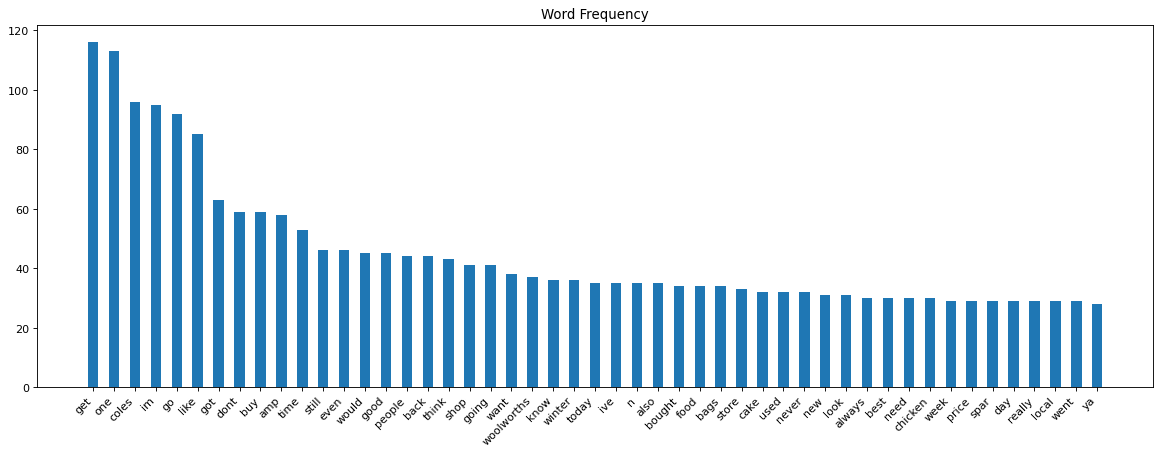

In [467]:
plot_most_common_words(df[df['week']==20],1)

In [471]:
df_w20 = predict_sentiments(df[df['week']==20])

plot_most_common_words(df_w20[df_w20['sentiment_prediction']=='positive'],1)

<ipython-input-470-d36071af7cb3>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment_prediction'] = [sent[i['label']] for i in res]
<ipython-input-470-d36071af7cb3>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['confidence'] = [i['score'] for i in res]


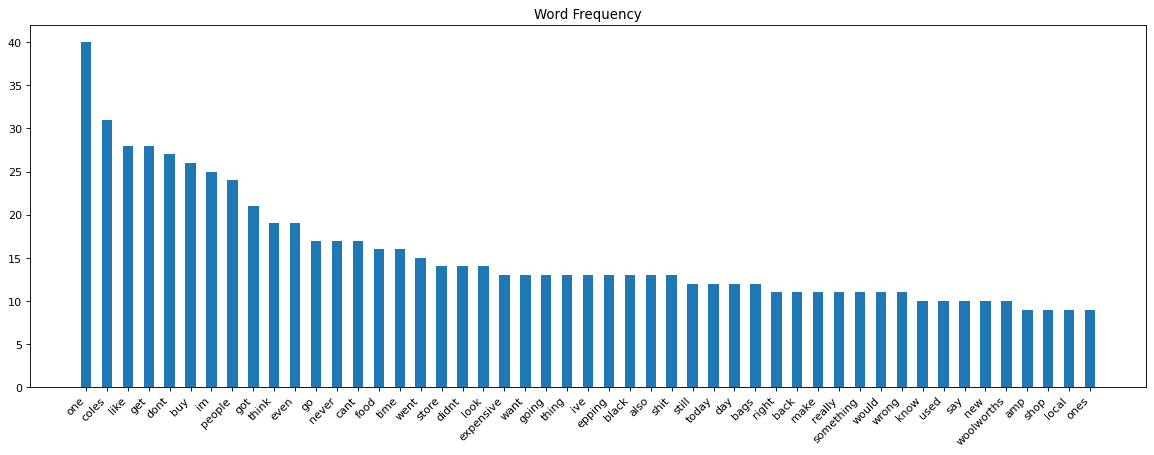

In [478]:
plot_most_common_words(df_w20[df_w20['sentiment_prediction']=='negative'],1)

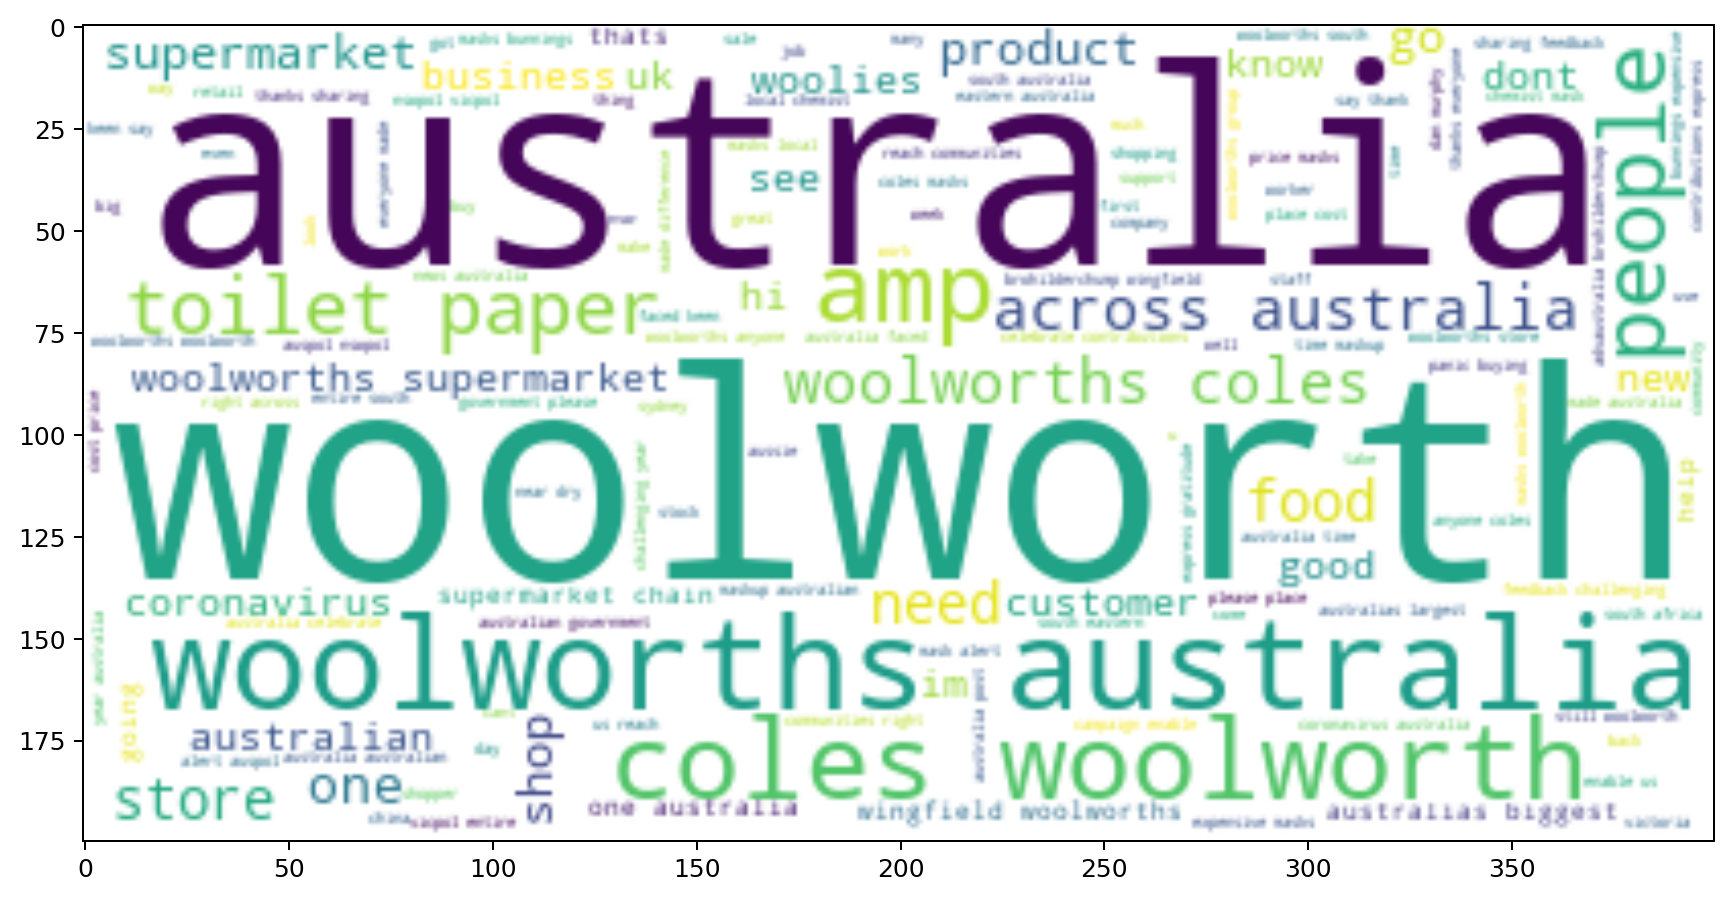

In [23]:
tweets = re.sub('\n', '', re.sub(r'[^a-zA-Z0-9\s\n]', '', ' '.join(list(df['Text']))))

plt.figure(figsize=(12, 6), dpi=180)

data = tweets.split(' ')

stop_words = stopwords.words('english')

filtered_data = [w for w in data if not w.lower() in stop_words]
filtered_data = [word.lower() for word in filtered_data if word.isalpha()]

wordcloud = WordCloud(background_color='white').generate(' '.join(filtered_data))

plt.imshow(wordcloud, interpolation='bilinear')

In [548]:
df_w22_imp = get_most_impactful_tweets(df[df['week']==22])

<ipython-input-547-d4bb0adc4e2f>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_zscore]=(df[col]-df[col].mean())/df[col].std()
<ipython-input-547-d4bb0adc4e2f>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n_df['score'] = 4*n_df['Followers_zscore']+4*n_df['Retweets_zscore']+n_df['Tweet Likes_zscore']+n_df['Tweet Replies_zscore']


In [549]:
df_w22_imp

,Datetime,Tweet Id,Text,Username,Followers,Favourites,Location,Friends,Retweets,Tweet Likes,Tweet Replies,date,week,Followers_zscore,Retweets_zscore,Tweet Likes_zscore,Tweet Replies_zscore,Favourites_zscore,score
0,2021-06-02 02:42:01+00:00,1399919203054804992,No cases linked to the Woolies mixup. I know t...,HaydenJOConnor,6045,54208,Melbourne from Hobart,613,83,380,14,2021-06-02 02:42:01+00:00,22,0.006153,28.748539,19.433980,6.584504,0.601169,141.037252
1,2021-06-03 13:41:09+00:00,1400447464679690240,@divinerakau I know this sounds overrated but ...,Karabo_Mokgoko,2066957,0,South Africa,2020368,0,2,1,2021-06-03 13:41:09+00:00,22,32.926482,-0.131085,-0.077483,0.120399,-0.593141,131.224506
2,2021-06-01 02:54:09+00:00,1399559868067901442,"Are you happy with your grocery bill? Mine, al...",btckr,11215,46255,NSW Far South Coast,7741,35,118,44,2021-06-01 02:54:09+00:00,22,0.088737,12.047070,5.910162,21.501667,0.425949,75.955057
3,2021-06-01 03:21:01+00:00,1399566628698787848,Or maybe the ‘identifying the wrong Epping Woo...,MatthewGuyMP,19918,12343,"Melbourne, Australia.",365,33,329,13,2021-06-01 03:21:01+00:00,22,0.227756,11.351175,16.801481,6.087265,-0.321200,69.204471
4,2021-05-31 00:03:15+00:00,1399154472488603648,"Woolies and Big W stores, as well as multiple ...",australian,758417,587,"Sydney, Australia",558,3,2,4,2021-05-31 00:03:15+00:00,22,12.024296,0.912757,-0.077483,1.612116,-0.580208,53.282844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1362,2021-06-03 13:36:27+00:00,1400446282745802753,@MalatjiMJ11 Trouble is one day some idiot is ...,Paulo81287663,2,82,,5,0,0,0,2021-06-03 13:36:27+00:00,22,-0.090375,-0.131085,-0.180718,-0.376839,-0.591334,-1.443398
1363,2021-06-01 08:57:16+00:00,1399651249956528128,@Tom4Jones @bairdyblues The stuff you find in ...,theunleashedal,2,653,"London, England",29,0,0,0,2021-06-01 08:57:16+00:00,22,-0.090375,-0.131085,-0.180718,-0.376839,-0.578754,-1.443398
1364,2021-06-02 07:38:16+00:00,1399993755776651266,@TimSmithMP The rate of infection has more to ...,KingStealthy,0,95,,5,0,0,0,2021-06-02 07:38:16+00:00,22,-0.090407,-0.131085,-0.180718,-0.376839,-0.591048,-1.443526
1365,2021-06-01 12:26:13+00:00,1399703830548283395,@SkyNewsAust @aclennell @ScottMorrisonMP Eppin...,UncleW81897542,0,304,,39,0,0,0,2021-06-01 12:26:13+00:00,22,-0.090407,-0.131085,-0.180718,-0.376839,-0.586443,-1.443526


(array([885.,  70.,   0.,  22.,   0.,   5.,   0.,   4.,   0.,   2.,   0.,
          0.,   1.,   0.,   4.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,
          0.,   2.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

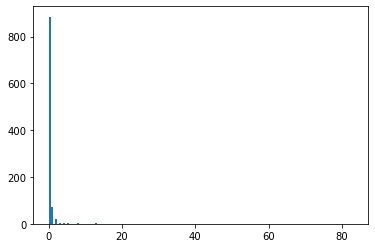

In [577]:
plt.hist(df_w22_imp['Retweets'].sample(1000),bins=150)

(array([886.,  72.,   0.,  20.,   0.,   5.,   0.,   4.,   0.,   1.,   1.,
          0.,   2.,   0.,   2.,   0.,   1.,   0.,   1.,   1.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

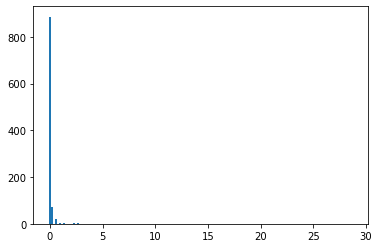

In [578]:
plt.hist(df_w22_imp['Retweets_zscore'].sample(1000),bins=150)